In [175]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.decomposition import PCA


# Data from https://archive.ics.uci.edu/ml/datasets/MHEALTH+Dataset#

Banos, O., Garcia, R., Holgado, J. A., Damas, M., Pomares, H., Rojas, I., Saez, A., Villalonga, C. mHealthDroid: a novel framework for agile development of mobile health applications. Proceedings of the 6th International Work-conference on Ambient Assisted Living an Active Ageing (IWAAL 2014), Belfast, Northern Ireland, December 2-5, (2014).

Banos, O., Villalonga, C., Garcia, R., Saez, A., Damas, M., Holgado, J. A., Lee, S., Pomares, H., Rojas, I. Design, implementation and validation of a novel open framework for agile development of mobile health applications. BioMedical Engineering OnLine, vol. 14, no. S2:S6, pp. 1-20 (2015).


In [147]:
data = pd.read_csv('mHealth_subject1.log', delimiter='\t', header=None)

columns = ['acc_chest_X','acc_chest_Y','acc_chest_Z',\
           'ecg_1','ecg_2',\
           'acc_left_ankle_X','acc_left_ankle_Y','acc_left_ankle_Z',\
           'gyro_left_ankle_X','gyro_left_ankle_Y','gyro_left_ankle_Z',\
           'magnet_left_ankle_X','magnet_left_ankle_Y','magnet_left_ankle_Z',\
           'acc_right_arm_X','acc_right_arm_Y','acc_right_arm_Z',\
           'gyro_right_arm_X','gyro_right_arm_Y','gyro_right_arm_Z',\
           'magnet_right_arm_X','magnet_right_arm_Y','magnet_right_arm_Z',\
          'label']

label_names = {0:'null_class',
          1:'standing_still',
          2:'sitting_relaxing',
          3:'lying_down',
          4:'walking',
          5:'climbing_stairs',
          6:'waist_bends',
          7:'arm_elevation',
          8:'crouching',
          9:'cycling',
          10:'jogging',
          11:'running',
          12:'jumping'}
data.columns = columns

print('Shape of data:',data.shape)

# drop the null class
data = data[data.label!=0]

Shape of data: (161280, 24)


# Correlation Heatmap

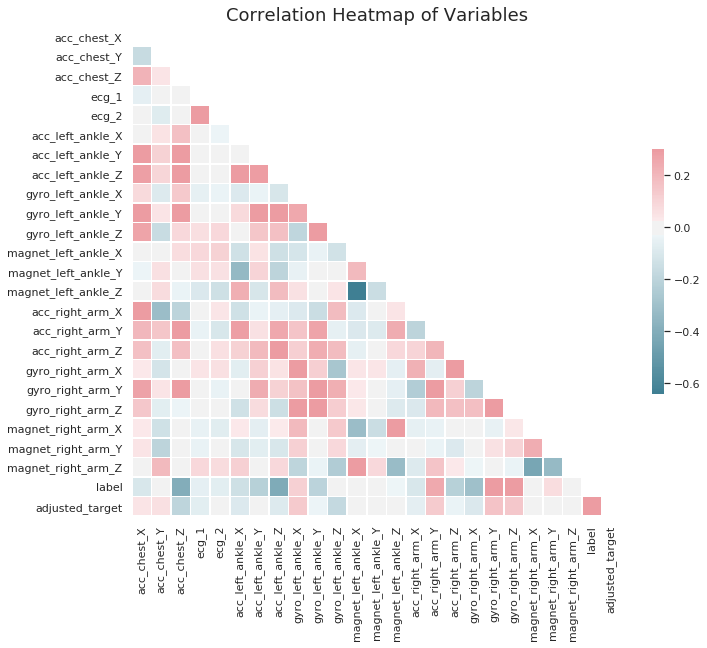

In [123]:
sns.set(style="white")
corr=data.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax.set_title('Correlation Heatmap of Variables', fontdict={'fontsize':18})
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

# Predict Classes

## Step 1: Try 1 vs not 1 for each class on basic random forest classifier

In [120]:
d = defaultdict(lambda: defaultdict(int))

for val in np.sort(data['label'].unique()):
    val_name = label_names[val]
    rf = RandomForestClassifier(n_estimators=100,class_weight='balanced', oob_score=True)
    data['adjusted_target'] = [1 if x==val else 0 for x in data['label']]
    y = data['adjusted_target'].copy()
    X = data.copy().drop(['label','adjusted_target'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    rf = RandomForestClassifier(n_estimators=100, oob_score=True)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    d[val_name]['test_acc'] = accuracy_score(y_test, y_pred)
    d[val_name]['test_prec'] = precision_score(y_test, y_pred)
    d[val_name]['test_rec'] = recall_score(y_test, y_pred)
    d[val_name]['oob_score'] = rf.oob_score_

In [122]:
scores = pd.DataFrame.from_dict(d).T
scores.sort_values(by='test_prec')

,oob_score,test_acc,test_prec,test_rec
jogging,0.998642,0.998708,0.996910,0.987755
running,0.998175,0.996813,0.997036,0.967402
jumping,0.998048,0.997416,0.997326,0.927861
standing_still,1.000000,1.000000,1.000000,1.000000
sitting_relaxing,1.000000,1.000000,1.000000,1.000000
lying_down,1.000000,1.000000,1.000000,1.000000
walking,0.999576,0.999483,1.000000,0.993909
climbing_stairs,0.999533,0.999828,1.000000,0.998028
waist_bends,0.999958,1.000000,1.000000,1.000000
arm_elevation,0.999830,1.000000,1.000000,1.000000


## Step 2: Predict all classes with same basic random forest

In [124]:
rf = RandomForestClassifier(n_estimators=100,class_weight='balanced', oob_score=True)
y = data['label'].copy()
X = data.copy().drop(['label','adjusted_target'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
rf = RandomForestClassifier(n_estimators=100, oob_score=True)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [125]:
y_pred_test = rf.predict(X_test)

### Results

In [126]:
test_acc = accuracy_score(y_test, y_pred_test)
test_prec_micro = precision_score(y_test, y_pred_test, average='micro')
test_rec_micro = recall_score(y_test, y_pred_test, average='micro')
oob_score = rf.oob_score_
test_prec_macro = precision_score(y_test, y_pred_test, average='macro')
test_rec_macro = recall_score(y_test, y_pred_test, average='macro')

In [155]:
print('Test Accuracy: {:.4f}'.format(test_acc))
print('Test precision micro: {:.4f}'.format(test_prec_micro))
print('Test precision macro: {:.4f}'.format(test_prec_macro))
print('Test recall micro: {:.4f}'.format(test_rec_micro))
print('Test recall macro: {:.4f}'.format(test_rec_macro))
print('Oob Score: {:.4f}'.format(oob_score))

Test Accuracy: 0.9979
Test precision micro: 0.9979
Test precision macro: 0.9978
Test recall micro: 0.9979
Test recall macro: 0.9973
Oob Score: 0.9982


In [132]:
scores_by_label = defaultdict(lambda: defaultdict(int))
for val in np.sort(test['y_true'].unique()):
    subset = test[test['y_true']==val].copy()
    subset['y_true'] = 1
    subset['y_pred'] = [1 if x==val else 0 for x in subset['y_pred']]
    scores_by_label[val]['acc'] = accuracy_score(subset['y_true'], subset['y_pred'])
    scores_by_label[val]['prec'] = precision_score(subset['y_true'], subset['y_pred'])
    scores_by_label[val]['rec'] = recall_score(subset['y_true'], subset['y_pred'])

In [158]:
scores_by_label_df = pd.DataFrame.from_dict(scores_by_label).T
scores_by_label_df.sort_values(by='rec')

,acc,prec,rec
12,0.985075,1.0,0.985075
11,0.989453,1.0,0.989453
10,0.994898,1.0,0.994898
8,0.998188,1.0,0.998188
1,1.000000,1.0,1.000000
2,1.000000,1.0,1.000000
3,1.000000,1.0,1.000000
4,1.000000,1.0,1.000000
5,1.000000,1.0,1.000000
6,1.000000,1.0,1.000000


### Review incorrect predictions
- When wrong, is there a pattern to what the classifier is guessing? 
- Yes, it seems the majority of the confusion is between jogging, jumping and running.

In [156]:
test = X_test.copy()
test['y_pred'] = y_pred_test
test['y_true'] = y_test
test_incorrect = test[test['y_pred']!=test['y_true']].copy()
test_incorrect['y_true_name'] =  [label_names[x] for x in test_incorrect['y_true']]
test_incorrect['y_pred_name'] =  [label_names[x] for x in test_incorrect['y_pred']]

true_vs_preds = pd.pivot_table(test_incorrect, values='gyro_right_arm_Y', index='y_true_name', \
                               columns='y_pred_name', aggfunc='count', fill_value=0)
true_vs_preds

y_pred_name,arm_elevation,climbing_stairs,jogging,jumping,running
y_true_name,,,,,
crouching,1,1,0,0,0
jogging,0,0,0,1,4
jumping,0,0,2,0,4
running,0,0,10,1,0


### feature importance

In [157]:
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False).round(2)

gyro_right_arm_Y       0.12
gyro_left_ankle_X      0.11
gyro_left_ankle_Y      0.11
gyro_right_arm_X       0.10
gyro_right_arm_Z       0.08
gyro_left_ankle_Z      0.08
acc_chest_Z            0.08
acc_left_ankle_Z       0.07
acc_right_arm_Z        0.06
acc_left_ankle_X       0.03
acc_right_arm_Y        0.03
acc_right_arm_X        0.02
acc_chest_X            0.02
acc_left_ankle_Y       0.02
magnet_left_ankle_Z    0.02
magnet_left_ankle_X    0.01
magnet_right_arm_X     0.01
magnet_right_arm_Z     0.01
ecg_2                  0.01
ecg_1                  0.01
acc_chest_Y            0.00
magnet_left_ankle_Y    0.00
magnet_right_arm_Y     0.00
dtype: float64

# Use trained rf to predict activity for new person

In [162]:
data_unseen.head()

,acc_chest_X,acc_chest_Y,acc_chest_Z,ecg_1,ecg_2,acc_left_ankle_X,acc_left_ankle_Y,acc_left_ankle_Z,gyro_left_ankle_X,gyro_left_ankle_Y,...,acc_right_arm_X,acc_right_arm_Y,acc_right_arm_Z,gyro_right_arm_X,gyro_right_arm_Y,gyro_right_arm_Z,magnet_right_arm_X,magnet_right_arm_Y,magnet_right_arm_Z,label
14592,-9.1542,0.636840,0.89942,0.163270,0.029304,0.18314,-9.4906,-6.48310,-0.26716,-0.38649,...,-3.4535,-10.677,2.3412,-0.41176,-0.40452,0.012931,5.7608,19.5310,-1.1631,5
14593,-8.6233,0.357780,1.05330,0.234430,0.159080,0.82168,-7.3844,-3.78810,-0.34323,-0.49531,...,-3.6900,-10.950,1.9837,-0.37059,-0.41478,-0.049569,7.6851,14.4670,20.5870,5
14594,-7.8995,0.025462,0.66545,0.104660,0.138150,0.72112,-4.9427,-1.19830,-0.34323,-0.49531,...,-3.5923,-10.209,2.1458,-0.37059,-0.41478,-0.049569,10.8880,11.5560,41.2570,5
14595,-7.1550,0.172290,0.86814,-0.004186,0.096285,0.77815,-3.6571,-1.35220,-0.34323,-0.49531,...,-3.4404,-10.153,1.7319,-0.37059,-0.41478,-0.049569,12.0890,6.0666,56.1380,5
14596,-6.3325,0.462560,0.94689,-0.062794,0.075353,1.08600,-2.8553,-0.38191,-0.40445,-0.51220,...,-3.3067,-9.712,1.7956,-0.37059,-0.41478,-0.049569,12.7590,1.2614,66.3080,5


In [164]:
data_unseen = pd.read_csv('mHealth_subject2.log', delimiter='\t', header=None)
data_unseen.columns = columns
# drop the null class
data_unseen = data_unseen[data_unseen['label']!=0]
y_unseen = data_unseen['label']
X_unseen = data_unseen.drop('label', axis=1)
y_pred_unseen = rf.predict(X_unseen)

In [166]:
test_acc = accuracy_score(y_unseen, y_pred_unseen)
test_prec_micro = precision_score(y_unseen, y_pred_unseen, average='micro')
test_rec_micro = recall_score(y_unseen, y_pred_unseen, average='micro')
test_prec_macro = precision_score(y_unseen, y_pred_unseen, average='macro')
test_rec_macro = recall_score(y_unseen, y_pred_unseen, average='macro')
print('Test Accuracy: {:.4f}'.format(test_acc))
print('Test precision micro: {:.4f}'.format(test_prec_micro))
print('Test precision macro: {:.4f}'.format(test_prec_macro))
print('Test recall micro: {:.4f}'.format(test_rec_micro))
print('Test recall macro: {:.4f}'.format(test_rec_macro))

Test Accuracy: 0.3954
Test precision micro: 0.3954
Test precision macro: 0.3691
Test recall micro: 0.3954
Test recall macro: 0.3778


/home/alex/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [172]:
data_unseen['y_pred']=y_pred_unseen
data_unseen['y_true']=data_unseen['label']

scores_by_label = defaultdict(lambda: defaultdict(int))
for val in np.sort(test['y_true'].unique()):
    subset = data_unseen[data_unseen['y_true']==val].copy()
    subset['y_true'] = 1
    subset['y_pred'] = [1 if x==val else 0 for x in subset['y_pred']]
    scores_by_label[val]['acc'] = accuracy_score(subset['y_true'], subset['y_pred'])
    scores_by_label[val]['prec'] = precision_score(subset['y_true'], subset['y_pred'])
    scores_by_label[val]['rec'] = recall_score(subset['y_true'], subset['y_pred'])
scores_by_label_df = pd.DataFrame.from_dict(scores_by_label).T
scores_by_label_df['label'] = [label_names[x] for x in scores_by_label_df.index]
scores_by_label_df.sort_values(by='acc')

/home/alex/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/alex/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/alex/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/alex/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/alex/anaconda3/lib/python3.6/site-packages/sklearn/met

,acc,prec,rec,label
1,0.000000,0.0,0.000000,standing_still
2,0.000000,0.0,0.000000,sitting_relaxing
6,0.000000,0.0,0.000000,waist_bends
8,0.000000,0.0,0.000000,crouching
12,0.000000,0.0,0.000000,jumping
3,0.089844,1.0,0.089844,lying_down
11,0.448893,1.0,0.448893,running
7,0.466947,1.0,0.466947,arm_elevation
10,0.686198,1.0,0.686198,jogging
4,0.910807,1.0,0.910807,walking


In [174]:
unseen_incorrect = data_unseen[data_unseen['y_pred']!=data_unseen['y_true']].copy()
unseen_incorrect['y_true_name'] =  [label_names[x] for x in unseen_incorrect['y_true']]
unseen_incorrect['y_pred_name'] =  [label_names[x] for x in unseen_incorrect['y_pred']]

true_vs_preds = pd.pivot_table(unseen_incorrect, values='gyro_right_arm_Y', index='y_true_name', \
                               columns='y_pred_name', aggfunc='count', fill_value=0)
true_vs_preds

y_pred_name,arm_elevation,climbing_stairs,crouching,cycling,jogging,jumping,running,standing_still,waist_bends,walking
y_true_name,,,,,,,,,,
arm_elevation,0,1388,332,0,0,0,0,0,54,0
climbing_stairs,1,0,67,7,21,1,16,0,13,85
crouching,0,3374,0,0,0,0,0,56,0,0
jogging,0,107,0,20,0,9,739,0,0,89
jumping,0,974,24,0,0,0,23,3,0,0
lying_down,0,0,0,0,2327,0,469,0,0,0
running,0,143,0,19,1342,21,0,0,0,168
sitting_relaxing,0,0,0,0,3072,0,0,0,0,0
standing_still,0,0,0,0,0,0,0,0,0,3072


In [177]:
pca = PCA(n_components=6)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=6, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [181]:
exp_var = pca.explained_variance_ratio_

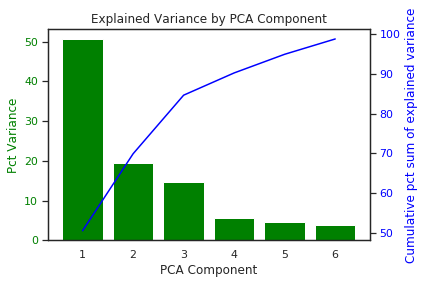

''

In [205]:
fig, ax = plt.subplots()
pca_component_names = np.arange(1,exp_var.shape[0] + 1)
color = 'green'
ax.bar(pca_component_names, exp_var*100, color=color)
ax.set_title('Explained Variance by PCA Component')
ax.set_xlabel('PCA Component')
ax.set_ylabel('Pct Variance',color=color)
ax.tick_params(axis='y', labelcolor=color)

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

color = 'blue'
ax2.set_ylabel('Cumulative pct sum of explained variance', color=color)  # we already handled the x-label with ax1
ax2.plot(pca_component_names, np.cumsum(exp_var)*100, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
;

In [214]:
pca_component_1 = pd.DataFrame(pca.components_[0], index=X.columns, columns=['component_weights'])
pca_component_1['weights_abs'] = np.abs(pca_component_1)
pca_component_1.sort_values(by='weights_abs', ascending=False)

,component_weights,weights_abs
magnet_right_arm_Z,-0.795606,0.795606
magnet_left_ankle_X,-0.499860,0.499860
magnet_left_ankle_Z,0.227466,0.227466
magnet_right_arm_X,0.195117,0.195117
magnet_left_ankle_Y,-0.129797,0.129797
magnet_right_arm_Y,0.102138,0.102138
acc_right_arm_X,0.005050,0.005050
acc_right_arm_Y,-0.003735,0.003735
acc_chest_Y,-0.002714,0.002714
acc_chest_Z,-0.001998,0.001998


##  Plot pca 3d and colors of each state

In [233]:
data_unseen_pca = pca.transform(X_unseen)
data_unseen['pca_1'] = data_unseen_pca[:,0]
data_unseen['pca_2'] = data_unseen_pca[:,1]
data_unseen['pca_3'] = data_unseen_pca[:,2]

In [234]:
data_unseen.head()

,acc_chest_X,acc_chest_Y,acc_chest_Z,ecg_1,ecg_2,acc_left_ankle_X,acc_left_ankle_Y,acc_left_ankle_Z,gyro_left_ankle_X,gyro_left_ankle_Y,...,gyro_right_arm_Z,magnet_right_arm_X,magnet_right_arm_Y,magnet_right_arm_Z,label,y_pred,y_true,pca_1,pca_2,pca_3
14592,-9.1542,0.636840,0.89942,0.163270,0.029304,0.18314,-9.4906,-6.48310,-0.26716,-0.38649,...,0.012931,5.7608,19.5310,-1.1631,5,5,5,58.665573,-68.033976,27.417123
14593,-8.6233,0.357780,1.05330,0.234430,0.159080,0.82168,-7.3844,-3.78810,-0.34323,-0.49531,...,-0.049569,7.6851,14.4670,20.5870,5,5,5,34.453979,-75.767202,19.400028
14594,-7.8995,0.025462,0.66545,0.104660,0.138150,0.72112,-4.9427,-1.19830,-0.34323,-0.49531,...,-0.049569,10.8880,11.5560,41.2570,5,5,5,5.837797,-64.548064,27.865049
14595,-7.1550,0.172290,0.86814,-0.004186,0.096285,0.77815,-3.6571,-1.35220,-0.34323,-0.49531,...,-0.049569,12.0890,6.0666,56.1380,5,5,5,-18.810348,-48.377044,39.916216
14596,-6.3325,0.462560,0.94689,-0.062794,0.075353,1.08600,-2.8553,-0.38191,-0.40445,-0.51220,...,-0.049569,12.7590,1.2614,66.3080,5,5,5,-39.077874,-31.348361,50.013476


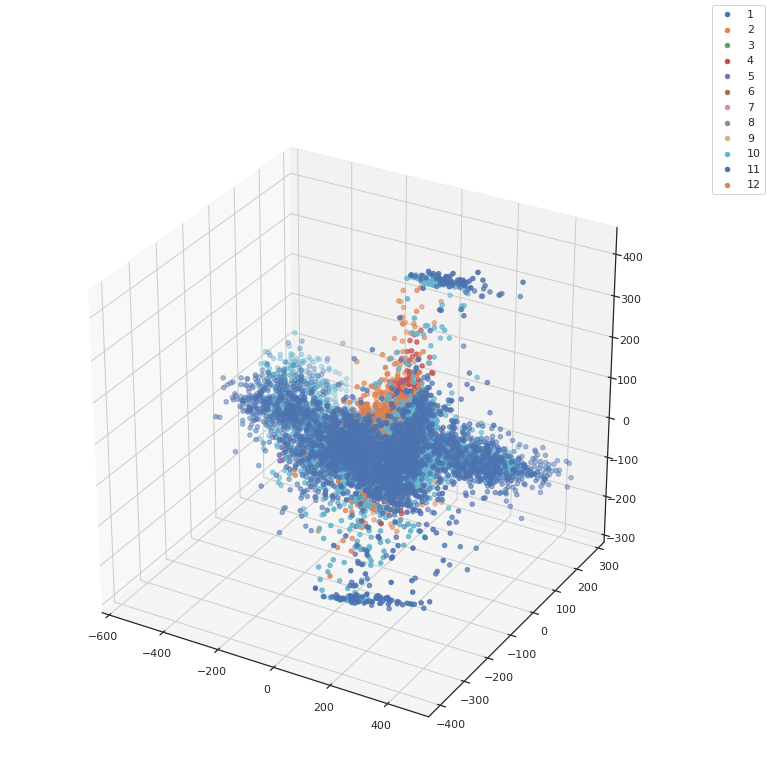

In [245]:
from mpl_toolkits.mplot3d import Axes3D
data_unseen_sample = data_unseen.sample(frac=0.05)
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
for label_val in np.sort(data_unseen['label'].unique()):
    data_label = data_unseen[data_unseen['label'] == label_val]
    ax.scatter(data_label['pca_1'],data_label['pca_2'],data_label['pca_3'], label=label_val, cmap=plt.cm.jet)
fig.legend();
